In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import kerastuner as kt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from scipy.sparse.linalg import eigsh
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.interpolate import RBFInterpolator
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

2025-07-24 21:38:49.491100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753402129.507286 1668224 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753402129.512417 1668224 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753402129.525131 1668224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753402129.525148 1668224 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753402129.525149 1668224 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tf.random.set_seed(314159)
np.random.seed(314159)

In [3]:
umin = 0.0
umax = 2*np.pi
vmin = -np.pi/2
vmax = np.pi/2

In [4]:
# Compute the area density function of the surface - p is a point (u,v)
def areaDensity(p, surface):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(p)
    u = p[:,0]
    v = p[:,1]
    s = surface(u, v)

  J = tape.batch_jacobian(s, p)

  s_u = J[:,:,0]
  s_v = J[:,:,1]

  cross_product = tf.linalg.cross(s_u, s_v)

  area = tf.norm(cross_product, keepdims=True, axis=1)

  return area

In [5]:
def findBound(surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, size_grid=100):
  u = tf.linspace(umin, umax, size_grid)
  v = tf.linspace(vmin, vmax, size_grid)

  u, v = tf.meshgrid(u, v)
  pts = tf.stack([tf.reshape(u, [-1]), tf.reshape(v, [-1])], axis=1)

  areas = areaDensity(pts, surface)

  return tf.reduce_max(areas)

In [6]:
rmin = 1.0
rmax = 0.9

In [7]:
tmin = 0.0
tmax = T_max = 1.0
tstep = 100

In [9]:
N_data = 2500
N_sensor = 512
N_inputs = 10000
modes = 64
width = 60
depth = 4

In [11]:
bf = lambda u, v: 1 + 0.2 * tf.sin(5.0 * v) * tf.sin(5.0 * u)

In [12]:
def sphere(u, v):
    return tf.stack([bf(u,v) * tf.sin(u) * tf.cos(v), bf(u,v) * tf.sin(u) * tf.sin(v), bf(u,v) * tf.cos(u)], axis=-1)

In [ ]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [ ]:
# Generate the projection matrix at a point p
def projMatrix(x, y, z, normals):
    p = tf.stack([x, y, z], axis=1)
    n = normals
    n = tf.expand_dims(n, axis=2)
    n_outer = tf.matmul(n, tf.transpose(n, [0, 2, 1]))
    I = tf.eye(3, batch_shape=[tf.shape(p)[0]])
    return I - n_outer

In [15]:
def generateRadii(n, rmin=rmin, rmax=rmax):
    radii = tf.random.uniform((n, 1), minval=rmin, maxval=rmax)

    return radii

In [17]:
eps = 1.0

In [21]:
def initial(x, y, z, radii, kx=1.0, ky=1.0, kz=1.0, c=1.0):
    u0 = tf.tanh(tf.cos(kx * x) * tf.cos(ky * y) * tf.cos(kz * z) * radii)

    return u0

In [22]:
def u_analytic(x, y, z, t, radii, kx=1.0, ky=1.0, kz=1.0, c=1.0):
    u0 = tf.tanh(c*t + tf.cos(kx * x) * tf.cos(ky * y) * tf.cos(kz * z) * radii)

    return u0

In [23]:
def generateDomainPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, saftey_factor=5):
  batch_size = n * saftey_factor

  max = findBound(surface, size_grid=100, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  U = tf.random.uniform((batch_size,), minval=umin, maxval=umax)
  V = tf.random.uniform((batch_size,), minval=vmin, maxval=vmax)
  W = tf.random.uniform((batch_size,), minval=0.0, maxval=1.0)

  P = tf.stack([U, V], axis=1)
  A = areaDensity(P, surface) / (max * 1.05)

  mask = W <= tf.squeeze(A)

  accept_U = tf.boolean_mask(U, mask)
  accept_V = tf.boolean_mask(V, mask)

  if tf.shape(accept_U)[0] < n or tf.shape(accept_V)[0] < n:
    print('Not enough points generated - increase saftey_factor')
    return
  accept_U = accept_U[0:n]
  accept_V = accept_V[0:n]
  domain_pts = tf.stack([accept_U, accept_V], axis=1)
  if tf.shape(domain_pts)[0] > n:
    domain_pts = domain_pts[:,0:n]

  return domain_pts

In [ ]:
def generateCollocationPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  domain_pts = generateDomainPoints(n, surface)
  xyz = surface(domain_pts[:,0], domain_pts[:,1])
  t = tf.random.uniform((n,), minval=tmin, maxval=tmax)

  return tf.stack([xyz[:,0], xyz[:,1], xyz[:,2], t], axis=1)

In [25]:
def generateInitialPoints(n, surface, radii, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0):
  xyz = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3]
  x = xyz[:,0:1]
  y = xyz[:,1:2]
  z = xyz[:,2:3]
  t = tf.ones_like(x) * tmin
  return [tf.concat([x, y, z, t], axis=1), initial(x, y, z, radii)]

In [26]:
def generateData(n, surface, sensor_points, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi):
    pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)
    x, y, z, t = pts[:,0:1], pts[:,1:2], pts[:,2:3], pts[:,3:4]

    data_coeffs = generateRadii(n)

    u_true = u_analytic(x, y, z, t, data_coeffs)

    data_pts = tf.squeeze(tf.stack([x, y, z, t, u_true], axis=1))

    x_sensor = sensor_points[:,:,0]
    y_sensor = sensor_points[:,:,1]
    z_sensor = sensor_points[:,:,2]

    data_sensors = initial(x_sensor, y_sensor, z_sensor, data_coeffs)

    return [data_pts, data_sensors, data_coeffs]

In [27]:
sensor_points = tf.expand_dims(generateCollocationPoints(N_sensor, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2)[:,0:3], axis=0)

I0000 00:00:1753402133.134868 1668224 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6


In [31]:
def generatePoints(n, surface, sensor_points, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  pde_pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)
  data = generateData(N_data, surface, sensor_points, umin=umin, umax=umax, vmin=vmin, vmax=vmax)
  # sensor_points = tf.tile(sensor_points, [n, 1, 1])

  x_sensor = sensor_points[:,:,0]
  y_sensor = sensor_points[:,:,1]
  z_sensor = sensor_points[:,:,2]
  
  radii = generateRadii(n)

  u_sensor_points = initial(x_sensor, y_sensor, z_sensor, radii)
  ic_pts = generateInitialPoints(n, surface, radii, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin)
  # ic_pts = tf.zeros((N_inputs, 5))

  return pde_pts, ic_pts, data, u_sensor_points, radii

In [32]:
pde_pts, ic_pts, data, u_sensor_pts, radii = generatePoints(N_inputs, sphere, sensor_points, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)

In [33]:
x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]

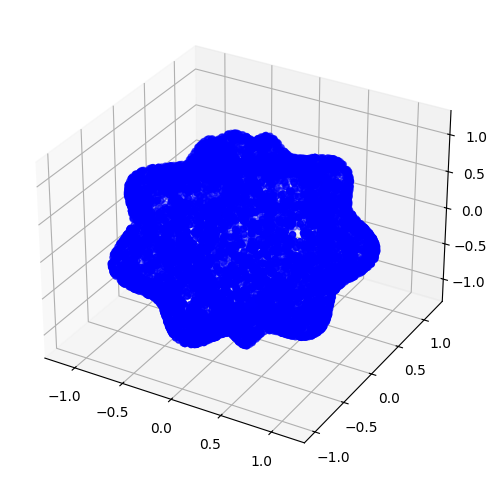

In [34]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2]
scatter = ax.scatter(x, y, z, color='blue')
plt.show()

In [35]:
print(pde_pts.shape)
print(ic_pts[0].shape)
print(data[1].shape)
print(u_sensor_pts.shape)
print(radii.shape)

(10000, 4)
(10000, 4)
(2500, 512)
(10000, 512)
(10000, 1)


In [ ]:
# Got this from AI
def compute_normal_jacobian(xyz, normals, k=200, h=0.5):
    """
    xyz: (N,3)
    normals: (N,3)
    k: number of neighbors
    h: length‐scale for Gaussian weighting
    returns: (N,3,3)
    """
    N = xyz.shape[0]
    jac = np.zeros((N, 3, 3), dtype=np.float32)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)

    for i in range(N):
        neigh = indices[i, 1:]
        A = xyz[neigh] - xyz[i]         # (k,3)
        B = normals[neigh] - normals[i] # (k,3)

        # Gaussian weights, shape (k,)
        w = np.exp(- (distances[i,1:]**2) / (h*h))
        # build weighted A and B
        Wsqrt = np.sqrt(w)[:, None]     # (k,1)
        Aw = A * Wsqrt                  # each row scaled
        Bw = B * Wsqrt

        # solve Aw @ J = Bw
        J, *_ = np.linalg.lstsq(Aw, Bw, rcond=None)
        jac[i] = J

    return jac

In [37]:
normals = normalVector(pde_pts[:,0:3])
normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

In [38]:
def eigens(pts, k=10):
  L, M = robust_laplacian.point_cloud_laplacian(pts.numpy())
  eigenvalues, eigenvectors = eigsh(L, k=k, M=M, which='LM', sigma=0.0)
  return eigenvalues, eigenvectors, M

In [39]:
def spectrals(efuncs, M):
  phi = tf.convert_to_tensor(efuncs, dtype=tf.float32)
  phi_dagger = tf.linalg.inv(tf.transpose(phi) @ (M @ phi)) @ tf.transpose(phi)
  return phi, phi_dagger

In [40]:
evals, efuncs, M = eigens(tf.squeeze(sensor_points), k=modes)
M = tf.convert_to_tensor(M.toarray(), dtype=tf.float32)
phi, phi_dagger = spectrals(efuncs, M)
spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(u_sensor_pts)))
data_sc = tf.transpose(phi_dagger @ (M @ tf.transpose(data[1])))

I0000 00:00:1753402140.459960 1668224 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x2edb6850


In [41]:
spectral_coefficients = u_sensor_pts
# data[1] = data_sc

In [42]:
spectral_coefficients.shape

TensorShape([10000, 512])

In [43]:
all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
# all_pts = pde_pts # use this one for hard contraint
pmin = tf.reduce_min(all_pts, axis=0)
pmax = tf.reduce_max(all_pts, axis=0)

smin = tf.reduce_min(spectral_coefficients, axis=1, keepdims=True) 
smax = tf.reduce_max(spectral_coefficients, axis=1, keepdims=True)

In [ ]:
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    # if inputs.shape[0] == 2:
    #   constant_part = inputs[0:1:,:,]
    #   other_part = inputs[1:2:,:,]
    #   other_part = 2.0*(other_part-self.xmin[1:2:,:,])/(self.xmax[1:2:,:,]-self.xmin[1:2:,:,])-1.0
    #   return tf.concat([constant_part, other_part], axis=0)
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [46]:
def buildModel(width, depth, modes):
  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))

  trunk_x = Normalize(pmin[0], pmax[0])(trunk_x)
  trunk_y = Normalize(pmin[1], pmax[1])(trunk_y)
  trunk_z = Normalize(pmin[2], pmax[2])(trunk_z)
  trunk_t = Normalize(pmin[3], pmax[3])(trunk_t)
  
  b = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z, trunk_t])

  # b = Normalize(pmin[0:2], pmax[0:2])(b)
  # b = Normalize(pmin, pmax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  # trunk_spatial = b

  # t = trunk_t
  # t = Normalize(pmin[2], pmax[2])(t)
  # for i in range(depth // 2):
  #   t = tf.keras.layers.Dense(width, activation='tanh')(t)
  # trunk_temporal = t  

  # trunk_out = tf.keras.layers.Concatenate()([trunk_spatial, trunk_temporal])
  trunk_out = b
  trunk_out = tf.keras.layers.Dense(width, activation='tanh')(trunk_out)

  branch_u = tf.keras.layers.Input(shape=(N_sensor,))
  branch_u = b = Normalize(smin[0], smax[0])(branch_u)

  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  branch_out = tf.keras.layers.Dense(width, activation='tanh')(b)

  out = tf.keras.layers.Multiply()([trunk_out, branch_out])
  # out = tf.keras.layers.Dense(2, activation='softplus')(out)
  out = tf.keras.layers.Dense(1, use_bias=True)(out)
  # out = tf.keras.layers.Activation('tanh')(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t, branch_u], out)

In [47]:
model = buildModel(width, depth, modes)

x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]
output = tf.squeeze(model([x, y, z, t, spectral_coefficients]))

output.shape

TensorShape([10000])

In [49]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [50]:
def hardConstraint(model, x, y, z, t, spectral_coefficients, u0, radii):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t, spectral_coefficients])
    u = u0 + (t - tmin) / (tmax - tmin) * nn
    # u = initial(x, y, z, radii) + nn

    return u

In [53]:
u0_pde = initial(pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], radii)
u0_data = initial(data[0][:,0:1], data[0][:,1:2], data[0][:,2:3], data[2])

In [54]:
@tf.function
def f(pde_pts, coefficients, normals, normal_jacobian):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  # x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

  with tf.GradientTape(persistent=True) as tape2:
    tape2.watch([x, y, z, t])
    u_pde = tf.squeeze(u_analytic(x, y, z, t, coefficients))

  ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

  uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
  uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
  uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

  uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
  uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
  uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

  grads = tf.concat([ux, uy, uz], axis=1)

  laplacians = uxx + uyy + uzz

  # normal = tempNormal(normal_model, xyz)# Collection of normal vectors at each point in pts

  directional_nu = tf.reduce_sum(normals * grads, axis=1) # Directional derivatives of u in direction of the normal

  row0 = tf.concat([uxx, uxy, uxz], axis=1)
  row1 = tf.concat([uxy, uyy, uyz], axis=1) 
  row2 = tf.concat([uxz, uyz, uzz], axis=1) 
  hessian = tf.stack([row0, row1, row2], axis=1)

  directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(hessian, tf.expand_dims(normals, axis=-1))), axis=1)

  # normal_jacobian = tape2.batch_jacobian(normal, xyz, unconnected_gradients=tf.UnconnectedGradients.ZERO)

  surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

  surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)
  surface_laplacians = tf.squeeze(laplacians) - surface_hess * directional_nu - directional_nu_second

  # laplacian_a = tf.squeeze(laplacian_approx(u_pde, L_pde, M_inv))

  return tf.squeeze(ut) + tf.reduce_sum(tf.expand_dims(u_pde, axis=1) * surface_grads, axis=1) - surface_laplacians

In [55]:
@tf.function
def trainingStep(model, optimizer, pde_pts, u0_pde, ic_pts, data, u_sensors, radii, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, lambda_d=1.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)

  # xi, yi, zi, ti = tf.split(ic_pts[0], 4, axis=1)
  # xi, yi, zi, ti = tf.squeeze(xi), tf.squeeze(yi), tf.squeeze(zi), tf.squeeze(ti)
  # ui = tf.squeeze(ic_pts[1])

  data_pts = data[0]
  data_sc = data[1]
  data_coeffs = data[2]

  xd, yd, zd, td, ud = tf.split(data_pts, 5, axis=1)
  xd, yd, zd, td = tf.squeeze(xd), tf.squeeze(yd), tf.squeeze(zd), tf.squeeze(td)
  ud = tf.squeeze(ud)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])

      net = tf.squeeze(hardConstraint(model, x, y, z, t, u_sensors, u0_pde, radii))

    u_pde = net

    ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # uncomment for laplacian
    uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    u_grads = tf.stack([ux, uy, uz], axis=1)

    u_laplacians = uxx + uyy + uzz

    u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    u_hessian = tf.stack([row0, row1, row2], axis=1)

    u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    u_surface_grads = u_grads - normals * tf.expand_dims(u_directional_nu, axis=-1)

    u_surface_laplacians = u_laplacians - u_surface_hess * u_directional_nu - u_directional_nu_second
    
    eqn = ut + tf.reduce_sum(tf.expand_dims(u_pde, axis=1) * u_surface_grads, axis=1) - u_surface_laplacians - f(pde_pts, radii, normals, normal_jacobian)

    pde_loss = tf.reduce_mean(eqn**2)

    # u_init_pred = tf.squeeze(hardConstraint(model, xi, yi, zi, ti, u_sensors, tf.expand_dims(ui, axis=-1), radii))

    # ic_loss = tf.reduce_mean((u_init_pred - ui)**2)

    data_pred = tf.squeeze(hardConstraint(model, xd, yd, zd, td, data_sc, u0_data, data_coeffs))

    data_loss = tf.reduce_mean((data_pred - ud) ** 2)

    # lambda_pde = data_loss / pde_loss

    loss = lambda_pde * pde_loss + lambda_d * data_loss

    ic_loss = 0.0

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, lambda_pde * pde_loss, ic_loss, lambda_d * data_loss

In [56]:
def train(model, optimizer, pde_pts, u0_pde, ic_pts, data, u_sensors, radii, normals, normal_jacobian, epochs=1000):
  losses = []
  pde_losses = []
  ic_losses = []
  data_losses = []
  l2s = []

  test_coeffs = generateRadii(1)

  batch_size = 512

  # ic_pts = tf.zeros((N_inputs, 5))

  dataset = (
  tf.data.Dataset.from_tensor_slices((pde_pts, u0_pde, radii, u_sensors, normals, normal_jacobian))
  .shuffle(N_inputs)
  .batch(batch_size)
  .prefetch(tf.data.AUTOTUNE)
            )

  ran_lbfgs = False

  # for epoch in range(epochs):   
  #   avg_loss = 0.0
  #   for pde_batch, ic_batch, radii_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
  #     if epoch < epochs // 2:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0) 
  #       avg_loss += loss  
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #     else:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
  #       avg_loss += loss
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #   losses.append(avg_loss / batch_size)

  for epoch in range(epochs):
    avg_loss = 0.0
    for pde_batch, u0_pde_batch, radii_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
      loss, pde_loss, ic_loss, data_loss = trainingStep(model, optimizer, pde_batch, u0_pde_batch, ic_pts, data, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, lambda_d=0.0)   
      avg_loss += loss
    # loss, pde_loss, ic_loss, data_loss = trainingStep(model, optimizer, pde_pts, ic_pts, data, u_sensors, radii, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, lambda_d=0.0)    
    losses.append(avg_loss / batch_size)
    # pde_losses.append(pde_loss)
    # data_losses.append(data_loss)

    if epoch % 100 == 0:
      # losses.append(total_loss / batch_size)
      x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]
      X_sens = sensor_points[:, :, 0]
      Y_sens = sensor_points[:, :, 1]
      Z_sens = sensor_points[:, :, 2]

      test_u_sensor = tf.tile(initial(X_sens, Y_sens, Z_sens, test_coeffs), multiples=[N_inputs, 1])

      test_spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(test_u_sensor)))
      test_spectral_coefficients = test_u_sensor
      u0_pde_test = initial(tf.expand_dims(x, axis=1), tf.expand_dims(y, axis=1), tf.expand_dims(z, axis=1), test_coeffs)
      u_pred = tf.squeeze(hardConstraint(model, x, y, z, t, test_spectral_coefficients, u0_pde_test, test_coeffs))
      x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
      u_true = tf.squeeze(u_analytic(x, y, z, t, test_coeffs))
      l2 = L2Error(u_true, u_pred)
      l2s.append(l2)
      print(f"Epoch {epoch} - PDE Loss {pde_loss: .6f} - IC Loss {ic_loss: .6f} - Data Loss {data_loss: .6f} Total Loss {loss: .6f} - L2 {l2: .4f}")
  
  return losses, pde_losses, ic_losses, data_losses, l2s

In [57]:
model = buildModel(width, depth, modes)


In [58]:
# model.load_weights('sphere_advec.weights.h5')

In [59]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.5)

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

mintime 0.0, maxtime 0.25


2025-07-24 21:39:11.238661: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-24 21:39:11.406357: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 - PDE Loss  0.956586 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.956586 - L2  0.1894


2025-07-24 21:39:11.697025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-24 21:39:12.267830: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-24 21:39:13.391471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-24 21:39:15.653481: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-24 21:39:20.214301: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - PDE Loss  0.031902 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.031902 - L2  0.0949


2025-07-24 21:39:29.174281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200 - PDE Loss  0.042166 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.042166 - L2  0.1017


2025-07-24 21:39:46.962341: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300 - PDE Loss  0.023592 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.023592 - L2  0.0905
Epoch 400 - PDE Loss  0.029624 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.029624 - L2  0.0951
Epoch 500 - PDE Loss  0.039340 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.039340 - L2  0.0944


2025-07-24 21:40:23.137900: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 600 - PDE Loss  0.035561 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.035561 - L2  0.0951
Epoch 700 - PDE Loss  0.036223 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.036223 - L2  0.0904
Epoch 800 - PDE Loss  0.034658 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.034658 - L2  0.0916
Epoch 900 - PDE Loss  0.012077 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.012077 - L2  0.0892


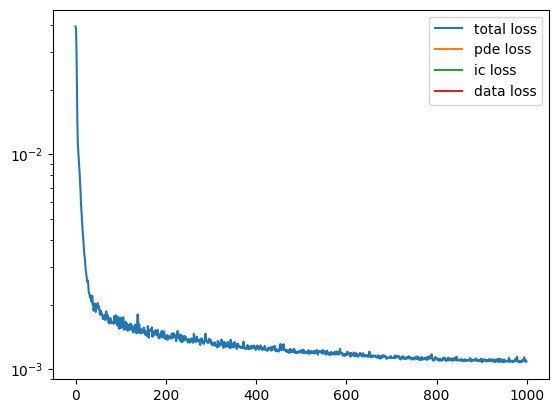

mintime 0.125, maxtime 0.5
Epoch 0 - PDE Loss  0.003712 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.003712 - L2  0.0885


2025-07-24 21:41:40.671945: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - PDE Loss  0.001167 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.001167 - L2  0.0899
Epoch 200 - PDE Loss  0.000827 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000827 - L2  0.0839
Epoch 300 - PDE Loss  0.000552 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000552 - L2  0.0784
Epoch 400 - PDE Loss  0.000407 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000407 - L2  0.0775
Epoch 500 - PDE Loss  0.000388 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000388 - L2  0.0784
Epoch 600 - PDE Loss  0.000339 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000339 - L2  0.0785
Epoch 700 - PDE Loss  0.000333 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000333 - L2  0.0786
Epoch 800 - PDE Loss  0.000269 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000269 - L2  0.0786
Epoch 900 - PDE Loss  0.000277 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000277 - L2  0.0787


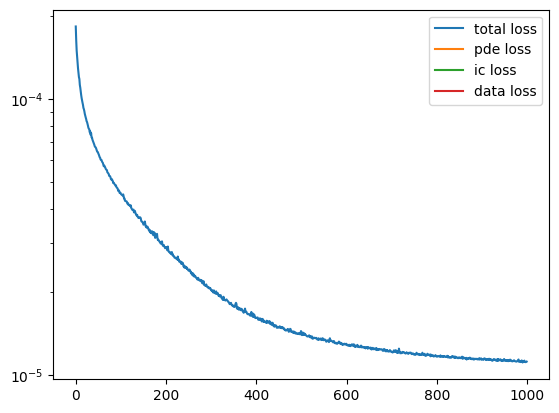

mintime 0.25, maxtime 0.75
Epoch 0 - PDE Loss  0.000505 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000505 - L2  0.0690


2025-07-24 21:44:09.662784: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - PDE Loss  0.000207 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000207 - L2  0.0694
Epoch 200 - PDE Loss  0.000252 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000252 - L2  0.0694
Epoch 300 - PDE Loss  0.000184 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000184 - L2  0.0693
Epoch 400 - PDE Loss  0.000185 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000185 - L2  0.0693
Epoch 500 - PDE Loss  0.000162 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000162 - L2  0.0693
Epoch 600 - PDE Loss  0.000171 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000171 - L2  0.0693
Epoch 700 - PDE Loss  0.000187 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000187 - L2  0.0693
Epoch 800 - PDE Loss  0.000195 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000195 - L2  0.0693
Epoch 900 - PDE Loss  0.000181 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000181 - L2  0.0693


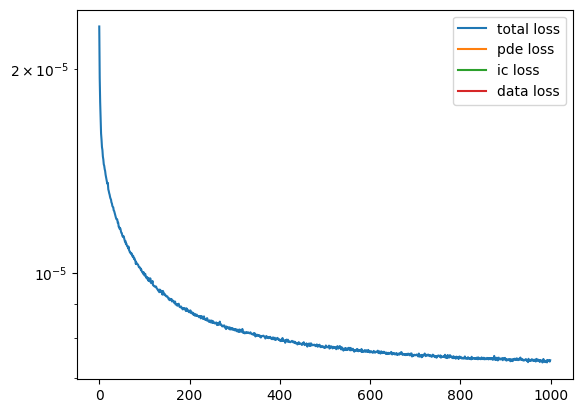

mintime 0.375, maxtime 1.0
Epoch 0 - PDE Loss  0.000542 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000542 - L2  0.0655
Epoch 100 - PDE Loss  0.000259 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000259 - L2  0.0649
Epoch 200 - PDE Loss  0.000332 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000332 - L2  0.0649
Epoch 300 - PDE Loss  0.000283 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000283 - L2  0.0649
Epoch 400 - PDE Loss  0.000296 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000296 - L2  0.0649
Epoch 500 - PDE Loss  0.000273 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000273 - L2  0.0649
Epoch 600 - PDE Loss  0.000268 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000268 - L2  0.0649
Epoch 700 - PDE Loss  0.000292 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000292 - L2  0.0649
Epoch 800 - PDE Loss  0.000274 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.000274 - L2  0.0649
Epoch 900 - 

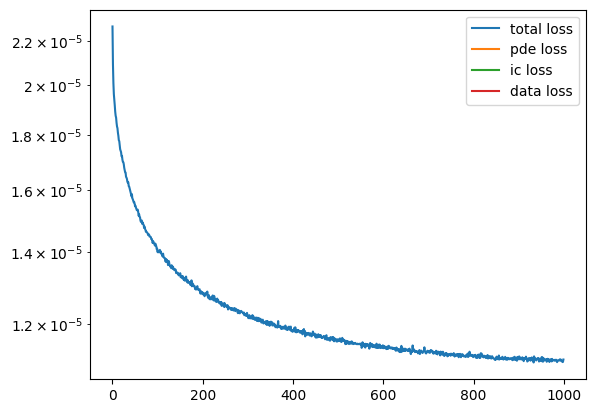

mintime 0.0, maxtime 1.0
Epoch 0 - PDE Loss  0.017802 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.017802 - L2  0.0674


2025-07-24 21:49:09.078236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - PDE Loss  0.046311 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.046311 - L2  0.0697
Epoch 200 - PDE Loss  0.021311 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.021311 - L2  0.0705
Epoch 300 - PDE Loss  0.054457 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.054457 - L2  0.0709
Epoch 400 - PDE Loss  0.015833 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.015833 - L2  0.0711
Epoch 500 - PDE Loss  0.009975 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.009975 - L2  0.0712
Epoch 600 - PDE Loss  0.023814 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.023814 - L2  0.0713
Epoch 700 - PDE Loss  0.037993 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.037993 - L2  0.0713
Epoch 800 - PDE Loss  0.039768 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.039768 - L2  0.0714
Epoch 900 - PDE Loss  0.026929 - IC Loss  0.000000 - Data Loss  0.000000 Total Loss  0.026929 - L2  0.0714


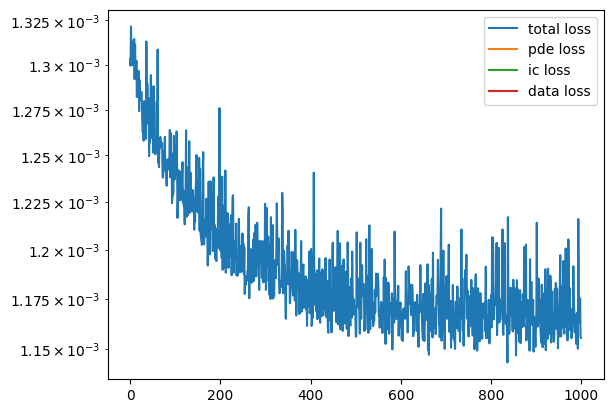

In [61]:
steps = 4
l2s = []
for i in range(1, steps+2):
    max_time = i * tmax / steps
    if i == steps + 1:
        max_time = tmax
        min_time = 0.0
    elif i == 1:
        min_time = 0.0
    else:
        min_time = 0.5 * ((i-1) * tmax / steps)
    print(f"mintime {min_time}, maxtime {max_time}")
    pde_pts, ic_pts, data, u_sensor_pts, radii = generatePoints(N_inputs, sphere, sensor_points, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=min_time, tmax=max_time)
    spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(u_sensor_pts)))
    spectral_coefficients = u_sensor_pts
    data_sc = tf.transpose(phi_dagger @ (M @ tf.transpose(data[1])))
    # data[1] = data_sc
    normals = normalVector(pde_pts[:,0:3])
    normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

    losses, pde_losses, ic_losses, data_losses, l2s = train(model, optimizer, pde_pts, u0_pde, ic_pts, data, spectral_coefficients, radii, normals, normal_jacobian, epochs=1000)
    losses = [l.numpy() for l in losses]
    pde_losses = [l.numpy() for l in pde_losses]
    ic_losses = [l.numpy() for l in ic_losses]
    data_losses = [l.numpy() for l in data_losses]
    plt.plot(losses, label='total loss')
    plt.plot(pde_losses, label='pde loss')
    plt.plot(ic_losses, label='ic loss')
    plt.plot(data_losses, label='data loss')
    plt.legend()
    # plt.xscale('log')
    plt.yscale('log')
    plt.show()

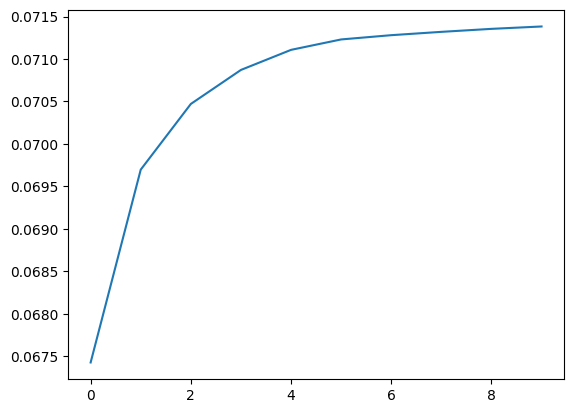

In [62]:
l2s = [l.numpy() for l in l2s]
plt.plot(l2s)
plt.show()
plt.show()

In [63]:
# losses, pde_losses, ic_losses, l2s, grads, uv2 = train(model, optimizer, pde_pts, ic_pts, spectral_coefficients, radii, normals, normal_jacobian, epochs=5000)
# losses = [l.numpy() for l in losses]
# pde_losses = [l.numpy() for l in pde_losses]
# ic_losses = [l.numpy() for l in ic_losses]
# uv2s = [l for l in uv2]

In [64]:
# model.save_weights('sphere_gs.weights.h5')

In [65]:
# plt.plot(losses, label='total loss')
# plt.plot(pde_losses, label='pde loss')
# plt.plot(ic_losses, label='ic loss')
# plt.legend()
# # plt.xscale('log')
# plt.yscale('log')

In [66]:
print(tf.random.normal((1,)))

tf.Tensor([-0.1934425], shape=(1,), dtype=float32)


In [67]:
test_pde_pts, test_ic_pts, _, test_u_sensor_pts, test_coefficients = generatePoints(N_inputs, sphere, sensor_points, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)

n_eval_pts = 100

test_coeffs = generateRadii(n_eval_pts)

mean_mae = tf.constant([0.0], dtype=tf.float32)
mean_l2 = tf.constant([0.0], dtype=tf.float32)

for i in range(n_eval_pts):
    ti = test_coeffs[i:i+1:,]
    X_sens = sensor_points[:, :, 0]
    Y_sens = sensor_points[:, :, 1]
    Z_sens = sensor_points[:, :, 2]

    test_u_sensor = tf.tile(initial(X_sens, Y_sens, Z_sens, ti), multiples=[N_inputs, 1])

    test_spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(test_u_sensor)))
    test_spectral_coefficients = test_u_sensor

    x, y, z, t = tf.split(test_pde_pts, 4, axis=1)
    u0_pde_test = initial(x, y, z, ti)
    u_pred = tf.squeeze(hardConstraint(model, x, y, z, t, test_spectral_coefficients, u0_pde_test, ti))
    u_true = tf.squeeze(u_analytic(x, y, z, t, ti))
    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
    mae = tf.reduce_mean(tf.abs(u_pred - u_true))
    l2 = L2Error(u_true, u_pred)
    mean_mae += mae
    mean_l2 += l2

print(f"Average MAE over {n_eval_pts} initial conditions: {float(mean_mae / n_eval_pts): .4f}")
print(f"Average L2 over {n_eval_pts} initial conditions: {float(mean_l2 / n_eval_pts): .4f}")

Average MAE over 100 initial conditions:  0.0428
Average L2 over 100 initial conditions:  0.0716


In [68]:
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim([z_middle - max_range/2, z_middle + max_range/2])


In [69]:
def modelResults(model, sensor_points, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  X_sens = sensor_points[:, :, 0]
  Y_sens = sensor_points[:, :, 1]
  Z_sens = sensor_points[:, :, 2]

  test_pde_pts, _, _, _ = generatePoints(resolution, sphere, sensor_points, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=tmin, tmax=tmax)

  radii = generateRadii(1)

  # u_sens_pts = tf.tile(u0(X_sens, Y_sens, Z_sens, radii), multiples=[resolution, 1])
  u_sens_pts = initial(X_sens, Y_sens, Z_sens, radii)
  
  test_spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(u_sens_pts)))

  # u = tf.linspace(umin, umax, resolution)
  # v = tf.linspace(vmin, vmax, resolution)

  # U, V = tf.meshgrid(u, v)

  # xyz = surface(u, v)
  # test_pde_pts = tf.reshape(xyz, [-1, 3])

  x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]

  # norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None

  u_norm_pred = None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps)
    pde_pts = tf.stack([x, y, z, t], axis=1)

    x, y, z = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1])

    u0 = initial(x, y, z, radii)

    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

    u_pred = tf.reshape(hardConstraint(model, x, y, z, t, test_spectral_coefficients, u0, radii), x.shape).numpy()
    if i == 0:
      u_norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()
  
    UP = u_pred.ravel()  
    # UP = np.where(UP >= 0.0, 1.0, -1.0)           

    fig = plt.figure(figsize=(12, 6))

    ax2    = fig.add_subplot(121, projection='3d')

    ax2.set_box_aspect([1, 1, 1])

    u_sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='coolwarm',
        norm=u_norm_pred,
        marker='o'
    )

    fig.colorbar(u_sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax2,    x, y, z)

    # ax2.view_init(elev=15, azim=250)
    print(f"t={i * tmax / t_steps}")



  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

In [70]:
def modelResults(model, true, surface, umin=0.0, umax=1.0, vmin=0.0, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  X_sens = sensor_points[:, :, 0]
  Y_sens = sensor_points[:, :, 1]
  Z_sens = sensor_points[:, :, 2]

  test_pde_pts, test_ic_pts, _, test_u_sensor_pts, test_coefficients = generatePoints(20000, sphere, sensor_points, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)

  test_coeffs = generateRadii(1)

  u_sens_pts = tf.tile(initial(X_sens, Y_sens, Z_sens, test_coeffs), multiples=[20000, 1])
  
  test_spectral_coefficients = tf.transpose(phi_dagger @ (M @ tf.transpose(u_sens_pts)))
  test_spectral_coefficients = u_sens_pts

  x, y, z = test_pde_pts[:,0], test_pde_pts[:,1], test_pde_pts[:,2]

  norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps)
    pde_pts = tf.stack([x, y, z, t], axis=1)

    u_actual = tf.reshape(u_analytic(x, y, z, t, test_coeffs), x.shape).numpy()
    u0_pde = initial(tf.expand_dims(x, axis=1), tf.expand_dims(y, axis=1), tf.expand_dims(z, axis=1), test_coeffs)
    u_pred = tf.reshape(hardConstraint(model, x, y, z, t, test_spectral_coefficients, u0_pde, test_coeffs), x.shape).numpy()

    u_abs = np.abs(u_actual - u_pred)

    print(f"L2 error at t={i * tmax / t_steps}: {L2Error(u_actual, u_pred): .4f}")

    norm = plt.Normalize(vmin=u_abs.min(), vmax=u_abs.max())
    if i == 0:
      norm_actual = plt.Normalize(vmin=0.4, vmax=1.0)
      norm_pred = plt.Normalize(vmin=0.4, vmax=1.0)
      # norm_actual = plt.Normalize(vmin=u_actual.min(), vmax=u_actual.max())
      # norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    colors = plt.cm.rainbow(norm(u_abs))
    colors_actual = plt.cm.magma(norm_actual(u_actual))
    colors_pred = plt.cm.magma(norm_pred(u_pred))

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()


    UA = u_actual.ravel()     
    UP = u_pred.ravel()       
    UABS = u_abs.ravel()      

    fig = plt.figure(figsize=(16, 6))
    ax_abs = fig.add_subplot(131, projection='3d')
    ax1    = fig.add_subplot(132, projection='3d')
    ax2    = fig.add_subplot(133, projection='3d')

    for ax in (ax_abs, ax1, ax2):
        ax.set_box_aspect([1,1,1])

    sc_abs = ax_abs.scatter(
        X, Y, Z,
        c=UABS,
        cmap='rainbow',
        norm=norm,
        marker='o'
    )

    sc_act = ax1.scatter(
        X, Y, Z,
        c=UA,
        cmap='magma',
        norm=norm_actual,
        marker='o'
    )
    sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='magma',
        norm=norm_pred,
        marker='o'
    )

    fig.colorbar(sc_abs,  ax=ax_abs, shrink=0.6)
    fig.colorbar(sc_act,  ax=ax1,  shrink=0.6)
    fig.colorbar(sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax_abs,  x, y, z)
    set_axes_equal_tensorflow(ax1,    x, y, z)
    set_axes_equal_tensorflow(ax2,    x, y, z)

    plt.show()
    ax1.view_init(elev=80)
    ax2.view_init(elev=80)


  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

L2 error at t=0.0:  0.0000


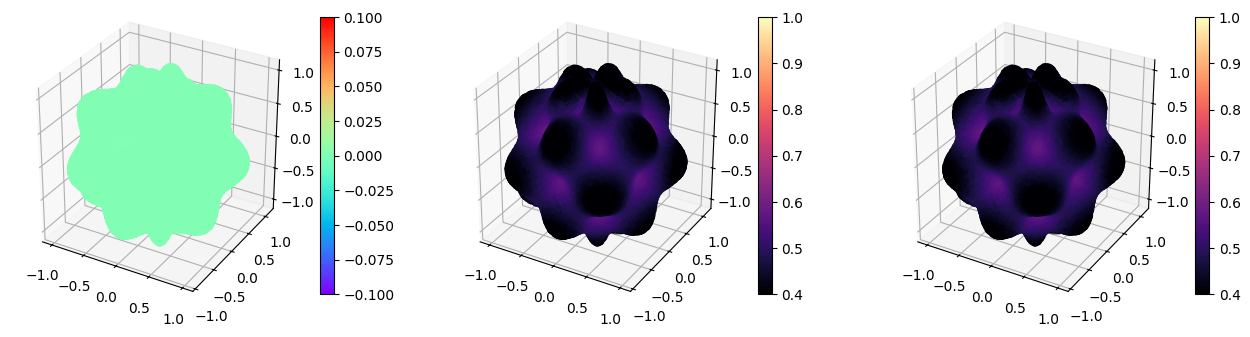

L2 error at t=0.3333333333333333:  0.0791


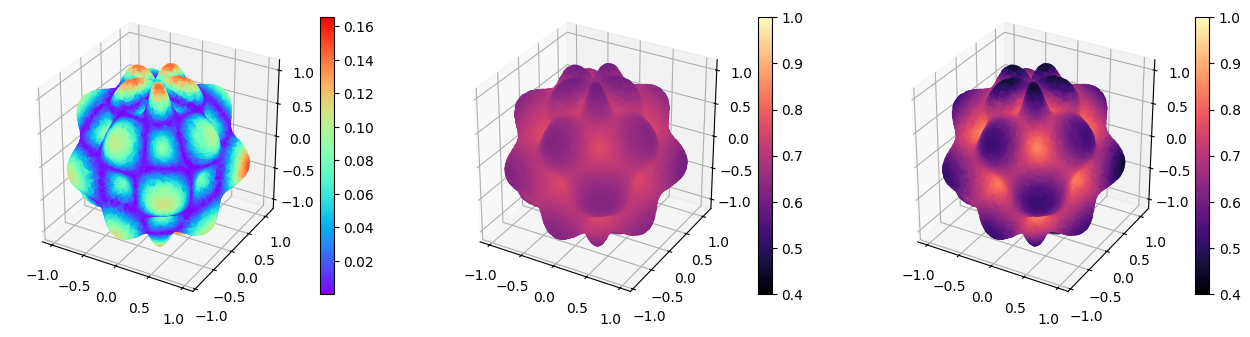

L2 error at t=0.6666666666666666:  0.0677


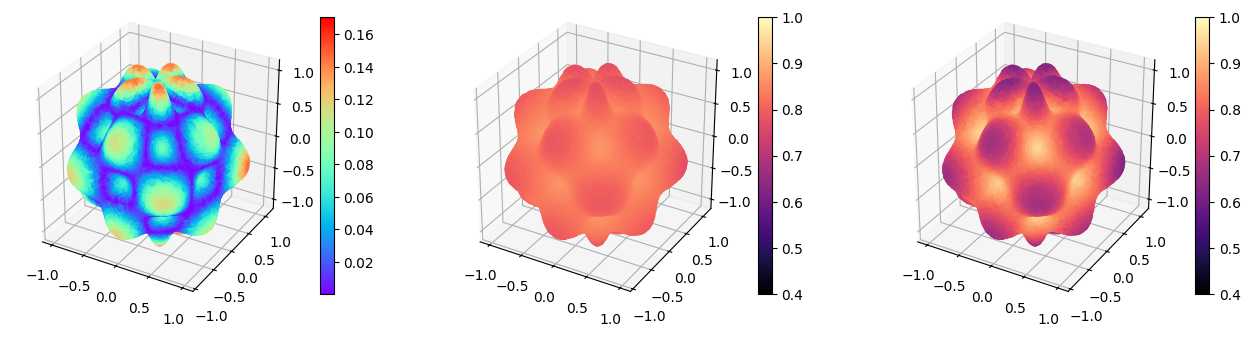

L2 error at t=1.0:  0.0650


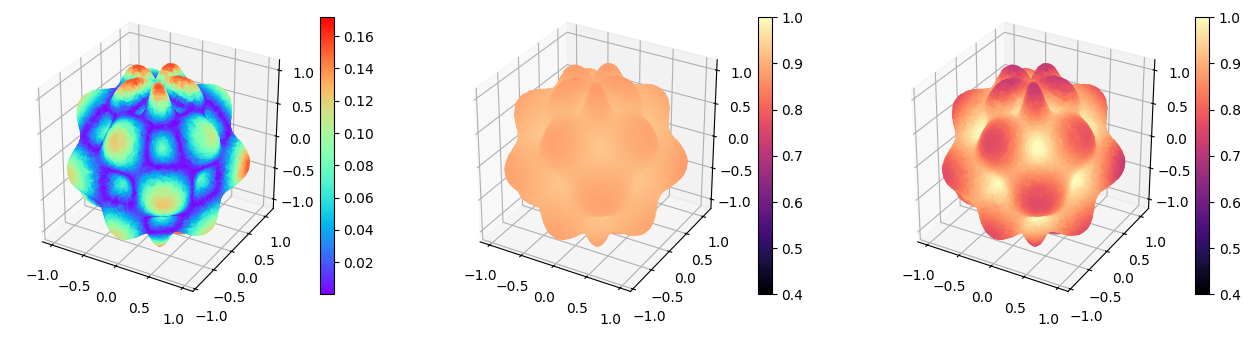

In [71]:
modelResults(model, sensor_points, sphere, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, t_steps=3, tmax=tmax, resolution=10000, load=False, saveplots=False)

In [ ]:
# model.save_weights('ac_bump_sphere.weights.h5')

: 